In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8
!pip install Theano==1.0.4

In [10]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
import arviz as az # trabajar bayesian y stats
import pymc3 as pm #paquete Jags
import pandas as pd
import seaborn as sns

# Us Likelihood Exponential - prior Gamma

Se utiliza para modelizar el tiempo que transcurre entre 2 eventos.

# Exemple

Vamos a analizar la variable "tiempo en minutos que esperamos" antes que nos atiendan.
Supongamos que tenemos una creencia, basada en estudios previos, que la espera media es de 10 minutos, pero no nos fiamos mucho, y aceptamos un margen de error de 10 (o sea que estaría entre 0-20). Indica poca fiabilidad en estos estudios.

# Distribució Gamma

La distribución conjugada para este tipo de análisis es la distribución gamma, y la función de verosimilitud se ajusta a la distribución exponencial.

$f_\Theta(\theta) = \frac{\beta^\alpha\theta^{\alpha - 1}e^{-\beta\theta}}{\Gamma(\alpha)}$

# Likelihood - Exponential

Funció de densitat:\

$f_{X_i|\Theta}(x_i|\theta) = \theta e^{-\theta x_i}$\

Likelihood Function:\

$f(X|\theta) = \theta^n e^{-\theta \sum x_i}$\

on:\
N -> número d'observacions\
$\sum x_i =$ suma d'observacions

# Posterior

$\text{Posterior} \propto \text{Likelihood} \times \text{Prior}$\

$\Rightarrow f_{\Theta | X}(\theta | x) \propto f_{x|\Theta}(x|\theta)\times f_\Theta(\theta)$\


$f_{\Theta | X}(\theta | x) \propto \theta^n e^{-\theta \sum x_i} \times \frac{\beta^\alpha\theta^{\alpha - 1}e^{-\beta\theta}}{\Gamma(\alpha)}$\

# Implementamos en R


Creamos la función de Verosimilitud donde:\

- lambda -> rango

- n_obs -> nº de observaciones

- sum_obs -> suma de todas las observaciones

Las observaciones las vamos a crear mediante una función aleatoria utilizando la función rgamma, con los siguientes datos:

media = 10 (minuts) -> $\mu$ (de la observación)

desviación tipo $\sigma$ = 10

De la distribución exponencial sabemos que:

$\theta = 1 / \mu$

$\theta^{2} = 1 / \sigma^{2}$

[]

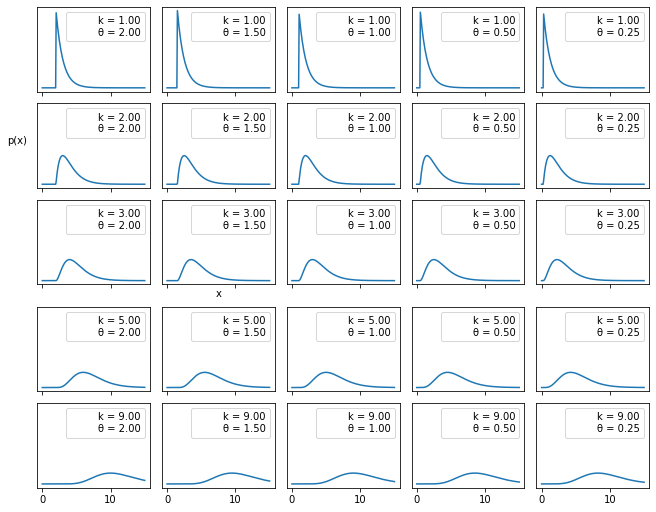

In [20]:
k_params = [1, 2, 3, 5, 9]
θ_params = [2, 1.5, 1, 0.5, 0.25]
x = np.linspace(0, 15, 200)
_, ax = plt.subplots(len(k_params), len(θ_params), sharex=True, 
                     sharey=True,
                     figsize=(9, 7), constrained_layout=True)
for i in range(5):
    for j in range(5):
        k = k_params[i]
        θ = θ_params[j]
        y = stats.gamma(k, θ).pdf(x)
        ax[i,j].plot(x, y)
        ax[i,j].plot([], label="k = {:3.2f}\nθ = {:3.2f}".format(k, 
                     θ), alpha=0)
        ax[i,j].legend(loc=1)
ax[2,1].set_xlabel('x')
ax[1,0].set_ylabel('p(x)', rotation=0, labelpad=20)
ax[1,0].set_yticks([])

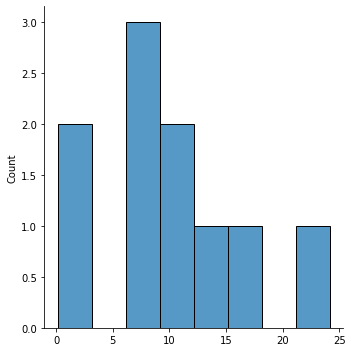

In [12]:
# En lugar de simular, cogemos los valores de la simulación en R para que los datos sean idénticos y comparamos resultados
#En R una serie en función de una lambda = 1/mu = 1/10 = 0.1 para 20 observaciones. Son tiempos de espera para 20 observaciones.

obs = np.array([0.1495641,  9.2022120,  7.5215894, 15.7504185,  2.3165862, 10.8667300, 23.2762287,  7.2912382, 12.8831010,  6.7226829])
sns.displot(obs,  binwidth=3)

Sobre ese lambda, parámetro desconocido no observable, es sobre el que hacemos inferencia y empezamos por una distribución a priori gamma. 

Si pensamos, a priori, que lambda tiene un valor de 0.1 (lo que supondría una media de 10 minutos de espera) podemos establecer un rango entre 0.001 (media de 1000)  y 0.25 (media de 4) 

Como varianza podemos pensar en una varianza de 1 que ya sería grande en este caso. 

Para la distribución gamma tenemos que calcular los parámetros (a,b) que tienen la siguiente relación con la variable a estudio $\theta$.

$E(\theta) = a/b$

$Var(\theta) = a/b^{2}$

Pero recordemos las relaciones entre $\theta$ y los datos iniciales.

Dato inicial, media de 10 minutos y margen (desviación tipo) de 10:

$\mu(\theta) = 1/10 = 0.1$

$\sigma(\theta) = 1/100 = 0.01$

In [14]:
a = 0.1
b = 0.01

with pm.Model() as model:
    θ = pm.Gamma('θ', alpha=a, beta=b) #prior
    y = pm.Exponential('y', θ, observed=obs) # Likelihood
    trace = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [θ]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [00:00<00:00, 2097.18it/s]


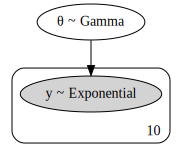

In [15]:
pm.model_to_graphviz(model) # mostramos la estructura

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f68de007e80>,
      dtype=object)

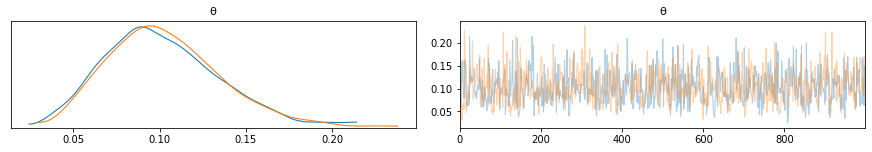

In [16]:
#dibujamos la posterior
az.plot_trace(trace)

In [17]:
# El valor en R ha sido del 0.1037928
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.103,0.033,0.047,0.168,0.001,0.001,923.0,923.0,851.0,994.0,1.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68ddc3aef0>],
      dtype=object)

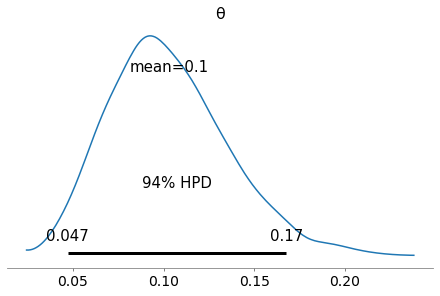

In [18]:
#Dibujamos la posterior
az.plot_posterior(trace)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f68dd93a828>],
      dtype=object)

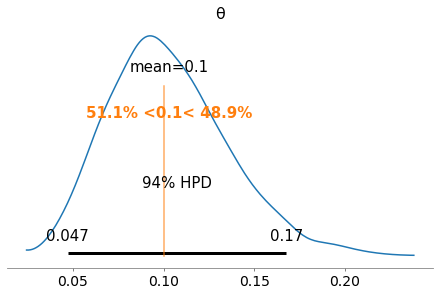

In [19]:
#Qué probabilidad hay que la distribución de la media esté por encima los 10 minutos? (theta = 1/10 = 0.1 -> q) El valor en R ha sido del 0.5086504
az.plot_posterior(trace, ref_val=0.1) 